In [1]:
from PIL import Image
import tensorflow as tf
import scipy.ndimage
from scipy import misc

from scipy.interpolate import RectBivariateSpline
import numpy as np
import numpy.matlib as ml
import random
import time
import os
import gc
import scipy.io

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("C:/Users/fedor/.conda/envs/tf-gpu/Lib/site-packages/tensorflow/contrib/slim")

C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\fedor\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\framework

In [2]:
tf.reset_default_graph()
slim = tf.contrib.slim

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [19]:
print("starting the job...")

num_out = 5    #number ouf output parameters being predicted

global numpix_side 
numpix_side = 192   #number of image pixels on the side

global max_noise_rms, max_psf_rms , max_cr_intensity
max_trainoise_rms = 0.1 # maximum rms of noise in training data
max_testnoise_rms = 0.1 # maximum rms of noise in test or validation data
max_noise_rms = max_testnoise_rms

max_psf_rms = 0.08/0.04  # maximum Gaussian PSF rms (in pixels)
max_cr_intensity = 0.5 # maximum scaling for cosmic ray and artefact maps

global constant_noise_rms
variable_noise_rms = True  #if True, the noise rms will be chosen randomly for each sample with a max of max_noise_rms (above)



global pix_res
pix_res = 0.04 # pixel size in arcsec
L_side = pix_res * numpix_side

global arcs_data_path_1, arcs_data_path_2 , test_data_path_1 , test_data_path_2 , CRay_data_path
global lens_data_path_1, lens_data_path_2, testlens_data_path_1, testlens_data_path_2 

global min_unmasked_flux 
min_unmasked_flux = 0.75

#number of folders containing training or test data. If all 3 point to the same folder that's OK (only that folder will be used).
global num_data_dirs
num_data_dirs = 3

num_training_samples = 79992

PATH_train = 'D:/'
PATH_test = 'D:/'

arcs_data_path_1 = PATH_train + 'lensed_images/'
arcs_data_path_2 = arcs_data_path_1
arcs_data_path_3 = arcs_data_path_1

test_data_path_1 = PATH_test + 'lensed_images_test/'
test_data_path_2 = test_data_path_1
test_data_path_3 = test_data_path_1

lens_data_path_1 = PATH_train + 'lensed_images/'
lens_data_path_2 = lens_data_path_1
lens_data_path_3 = lens_data_path_1

testlens_data_path_1 = PATH_test + 'lensed_images_test/'
testlens_data_path_2 = testlens_data_path_1
testlens_data_path_3 = testlens_data_path_1

#folder containing cosmic rays
CRay_data_path   = '../../data_Ensai/CosmicRays/'

global max_xy_range   # xy range of center of the lens. The image is shifted in a central area with a side of max_xy_range (arcsec) during training or testing
max_xy_range = 0.5

starting the job...


In [4]:
exec(open("get_data.py").read())
exec(open("ensai_model.py").read())

In [5]:
exec(open("inception_utils.py").read())
exec(open("inception.py").read())

In [6]:
arg_scope = inception_v4_arg_scope()
x = tf.placeholder(tf.float32, shape=[None, numpix_side*numpix_side])
y_ = tf.placeholder(tf.float32, shape=[None,num_out])    #placeholder for output parameters during training
input_tensor =  tf.reshape(x, [-1,numpix_side,numpix_side,1])
input_tensor = tf.concat([input_tensor,input_tensor,input_tensor], axis=3)

In [7]:
with slim.arg_scope(arg_scope):
        y_out = inception_v4(input_tensor , num_classes = 5 ,\
                             dropout_keep_prob=1.0 , is_training=True,create_aux_logits=False) 

Instructions for updating:
Use keras.layers.flatten instead.


In [8]:
variables_to_restore =  slim.get_variables(scope="InceptionV4")   #list of variables to save

In [9]:
restore_file = './ckpt/inception_model_tl.ckpt'   #path of network weights file to restore from

RESTORE = True
SAVE = False
restorer = tf.train.Saver(variables_to_restore)

In [10]:
############## flipping and cost function
MeanSquareCost , y_out_flipped = cost_tensor(y_out)

### Training

In [11]:
################ OPTIMIZER:
#learning_rate = 0.1
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(MeanSquareCost,var_list=train_pars)
##########################

In [12]:
num_test_samples = 200 # number of test samples
max_num_test_samples = 10003

X_test = np.zeros((num_test_samples,numpix_side*numpix_side), dtype='float32'  );
Y_test = np.zeros((num_test_samples,num_out), dtype='float32' );
MAG_test = np.zeros((num_test_samples,1), dtype='float32' );
Predictions = np.zeros((num_test_samples , num_out ) , dtype='float32' )
errors = np.zeros((num_test_samples , num_out ) , dtype='float32' )
# max_noise_rms = max_testnoise_rms

ind_t = range(num_test_samples)

In [13]:
read_data_batch(X_test, Y_test, MAG_test, max_num_test_samples, 'test')

In [14]:
opts = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)

sess = tf.Session(config=tf.ConfigProto(gpu_options=opts))
sess.run(tf.global_variables_initializer())

if RESTORE:
    restorer.restore(sess, restore_file)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./ckpt/inception_model_tl.ckpt


In [15]:
model_num = 'inception_v4'

sum_rms = 0
eval_cost = 0
chunk_size = 50
num_chunks = int(num_test_samples/chunk_size)
for it in range(num_chunks):
        #eval_cost  = eval_cost + sess.run(MeanSquareCost, feed_dict={x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]], y_: Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]})
        A = sess.run(y_out , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
        B = sess.run(y_out_flipped , feed_dict={ x: X_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it]]})
        Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = get_rotation_corrected(A,B,Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
        sum_rms = sum_rms + np.std(Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:],axis=0)
        errors[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:] = (Predictions[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:]- \
                                   Y_test[ind_t[0+chunk_size*it:chunk_size+chunk_size*it],:])
        
#eval_cost = eval_cost / num_chunks
print("mod"+ str(model_num) + ", "  + np.array_str( sum_rms/num_chunks  ,precision=2) )

modinception_v4, [0.09 0.09 0.11 0.08 0.09]


In [20]:
theta_68 = (np.percentile(errors[:,0], 84) - np.percentile(errors[:,0], 16))
elp_x_68 = (np.percentile(errors[:,1], 84) - np.percentile(errors[:,1], 16))
elp_y_68 = (np.percentile(errors[:,2], 84) - np.percentile(errors[:,2], 16))
x_68 = (np.percentile(errors[:,3], 84) - np.percentile(errors[:,3], 16))
y_68 =(np.percentile(errors[:,4], 84) - np.percentile(errors[:,4], 16))

print("[{:f} {:f} {:f} {:f} {:f}]".format(theta_68, elp_x_68, elp_y_68, x_68, y_68))

[0.136917 0.164230 0.174566 0.129626 0.153630]


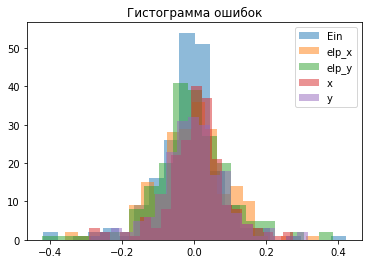

In [18]:
fig, ax = plt.subplots(1, 1)

ax.hist(errors[:,0], density = False, bins = 20, alpha = 0.5, label = 'Ein')
ax.hist(errors[:,1], density = False, bins = 20, alpha = 0.5, label = 'elp_x')
ax.hist(errors[:,2], density = False, bins = 20, alpha = 0.5, label = 'elp_y')
ax.hist(errors[:,3], density = False, bins = 20, alpha = 0.5, label = 'x')
ax.hist(errors[:,4], density = False, bins = 20, alpha = 0.5, label = 'y')
ax.legend()
ax.set_title('Гистограмма ошибок')
plt.show()

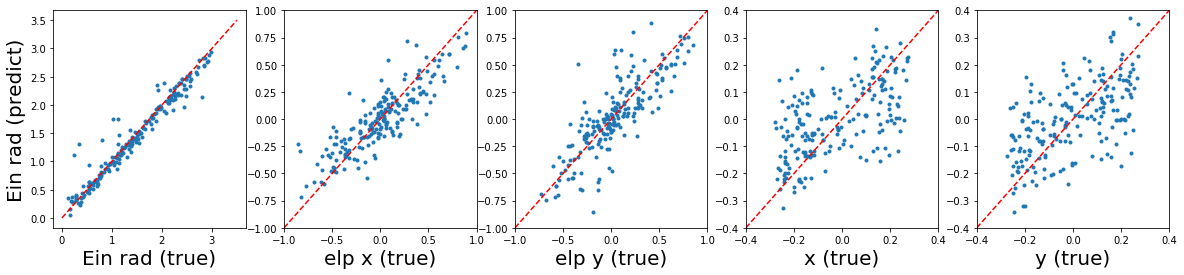

In [20]:
# And here's the fun part:
# plot the recovered parameters (y-axis) against their true values (x-axis)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.plot(Y_test[:,0],Predictions[:,0],' .')
plt.plot([0 , 3.5],[0 , 3.5],'--r')
plt.xlabel("Ein rad (true)", fontsize =20)
plt.ylabel("Ein rad (predict)", fontsize =20)
#plt.axis([0 ,3 ,0 ,3])

plt.subplot(1, 5, 2)
plt.plot(Y_test[:,1],Predictions[:,1],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp x (true)", fontsize =20)
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 3)
plt.plot(Y_test[:,2],Predictions[:,2],' .')
plt.plot([-1 , 1.],[-1 , 1.],'--r')
plt.xlabel("elp y (true)", fontsize =20)
plt.axis([-1 ,1 ,-1 ,1])


plt.subplot(1, 5, 4)
plt.plot(Y_test[:,3],Predictions[:,3],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("x (true)", fontsize =20)

plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])


plt.subplot(1, 5, 5)
plt.plot(Y_test[:,4],Predictions[:,4],' .')
plt.plot([-0.4 , 0.4],[-0.4 , 0.4],'--r')
plt.xlabel("y (true)", fontsize =20)
plt.axis([-0.4 ,0.4 ,-0.4 ,0.4])

plt.savefig("Inception_graphs.png")